# Descrição do Projeto

A empresa Sweet Lift Taxi coletou dados históricos sobre pedidos de táxi nos aeroportos. Para atrair mais motoristas durante o horário de pico, precisamos prever a quantidade de pedidos de táxi para a próxima hora. 	
Construa um modelo para tal predição.

A métrica REQM no conjunto de teste não deve ser superior a 48.

# Instruções do projeto

1. Faça download dos dados e faça uma nova amostragem em uma hora.
2. Analise os dados
3. Treine diferentes modelos com diferentes hiperparâmetros. A amostra de teste deve ser 10% do conjunto de dados inicial.
4. Teste os dados usando a amostra de teste e forneça uma conclusão.

# Descrição dos dados

Os dados são armazenados no arquivo `taxi.csv`. O número de pedidos está na coluna `num_orders`.

# Bibliotecas.

In [1]:
import pandas as pd
from pandas.plotting import autocorrelation_plot

from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression 
from sklearn.ensemble import RandomForestRegressor 
from catboost import CatBoostRegressor 
from lightgbm import LGBMRegressor 
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor 


# ignore warnings
import warnings
warnings.filterwarnings("ignore")

## Preparação 

Salvando dados na variavel data.

In [2]:
data = pd.read_csv('/datasets/taxi.csv',index_col=[0],parse_dates=[0])

In [3]:
# Amostra dos dados.
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
# Informações Gerais do dados.
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
# Os verificando se os dados estão ordenados.
data.index.is_monotonic

True

Os dados estão ordenados.

In [6]:
# Verificando se há dados ausentes nos dados.
print('Datas ausentes',data.index.isna().sum())
print('Numero de pedidos ausentes',data.isna().sum()[0])

Datas ausentes 0
Numero de pedidos ausentes 0


Não há valores ausentes.

In [7]:
print('Data de início dos dados',data.head(1).index[0])
print()
print('Data final dos dados',data.tail(1).index[0])

Data de início dos dados 2018-03-01 00:00:00

Data final dos dados 2018-08-31 23:50:00


### Conclusão.
Os dados foram carregados e submetidos a uma verificação, revelando a ausência de erros de tipo e de valores faltantes. Além disso, as datas estão devidamente ordenadas. A abrangência das informações abrange pedidos do período de 1º de março de 2018 a 31 de agosto de 2018.

## Análise

Text(0, 0.5, 'Pedidos')

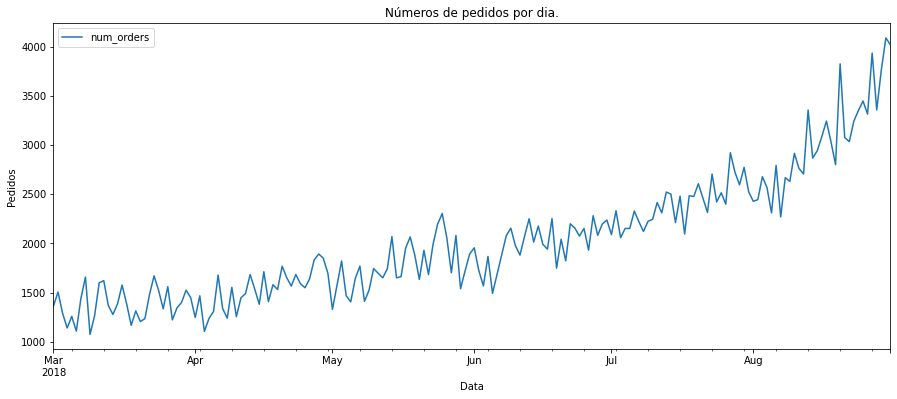

In [8]:
data.resample('1D').sum().plot(figsize=(15,6))
plt.title('Números de pedidos por dia.')
plt.xlabel('Data')
plt.ylabel('Pedidos')

**É possível observar que os picos de pedidos seguem um padrão distinto, e a tendência geral dos pedidos é de crescimento. Dado que o propósito deste projeto é prever a quantidade de pedidos por hora, é essencial analisar o comportamento dos pedidos ao longo das horas. No entanto, a partir deste gráfico, não é viável discernir se existem padrões específicos por hora.**

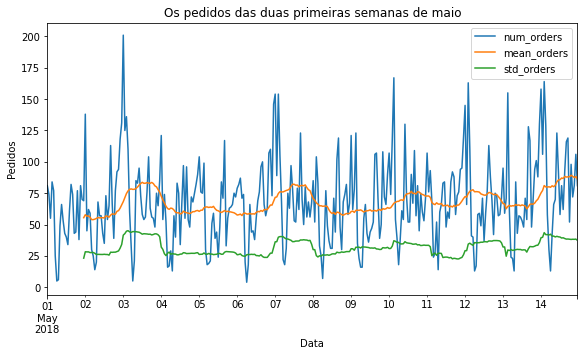

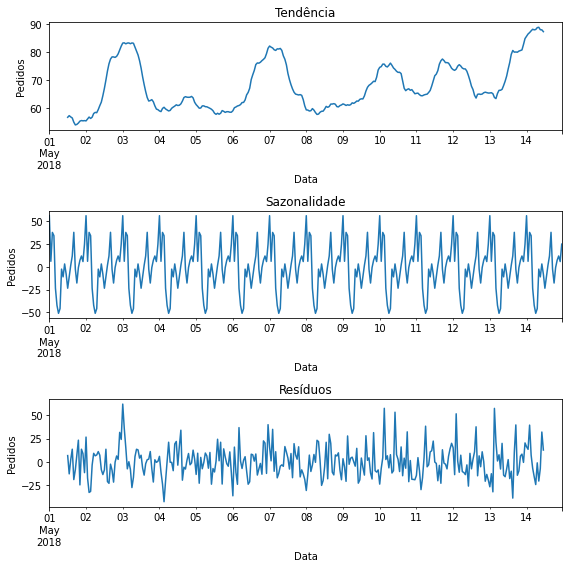

In [9]:
# Aqui esta sendo fatiado as duas primeiras semanas de maio e redimensionando os dados para pedidos por hora.
resample_1 = data['2018-05-01':'2018-05-14'].resample('1h').sum()
decomposed_1 = seasonal_decompose(resample_1)

# Adicionando a média móvel e desvio padrão móvel.
resample_1['mean_orders'] = resample_1['num_orders'].rolling(24).mean()
resample_1['std_orders'] = resample_1['num_orders'].rolling(24).std()

# Gráfico de pedidos de maio por hora.
resample_1.plot(figsize=(9.5, 5))
plt.title('Os pedidos das duas primeiras semanas de maio')
plt.xlabel('Data')
plt.ylabel('Pedidos')

# Gráfico do comportamento dos dados.
plt.figure(figsize=(8, 8))
# Tendência
plt.subplot(311)
decomposed_1.trend.plot(ax=plt.gca())
plt.title('Tendência')
plt.xlabel('Data')
plt.ylabel('Pedidos')
# Sazinalidade.
plt.subplot(312)
decomposed_1.seasonal.plot(ax=plt.gca())
plt.title('Sazonalidade')
plt.xlabel('Data')
plt.ylabel('Pedidos')
# Resíduos
plt.subplot(313)
decomposed_1.resid.plot(ax=plt.gca())
plt.title('Resíduos')
plt.xlabel('Data')
plt.ylabel('Pedidos')


plt.tight_layout()     

**O comportamento dos pedidos segue um padrão claro, o qual é evidente ao analisar tanto o gráfico de pedidos quanto o de sazonalidade. No entanto, essa tendência pode não ser tão perceptível em um período curto de tempo.**

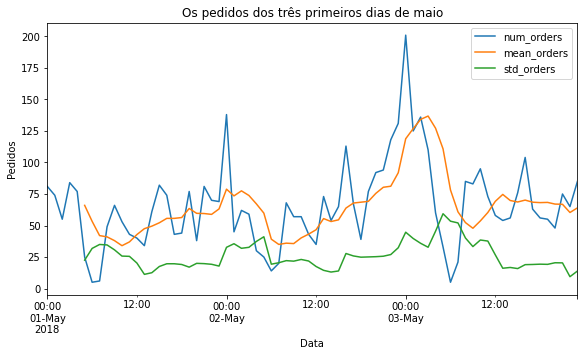

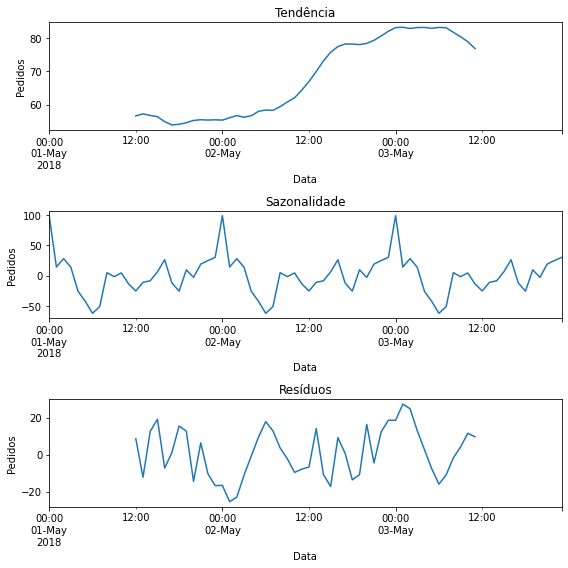

In [10]:
# Fatiando dados de 3 dias.
resample_2 = data['2018-05-01':'2018-05-03'].resample('1h').sum()
decomposed_2 = seasonal_decompose(resample_2)

# Adicionando a média móvel e desvio padrão móvel.
resample_2['mean_orders'] = resample_2['num_orders'].rolling(6).mean()
resample_2['std_orders'] = resample_2['num_orders'].rolling(6).std()


# Gráfico de pedidos de maio por hora.
resample_2.plot(figsize=(9.5, 5))
plt.title('Os pedidos dos três primeiros dias de maio')
plt.xlabel('Data')
plt.ylabel('Pedidos')

# Gráfico do comportamento dos dados
plt.figure(figsize=(8, 8))

# Tendência
plt.subplot(311)
decomposed_2.trend.plot(ax=plt.gca())
plt.title('Tendência')
plt.xlabel('Data')
plt.ylabel('Pedidos')
# Sazinalidade.
plt.subplot(312)
decomposed_2.seasonal.plot(ax=plt.gca())
plt.title('Sazonalidade')
plt.xlabel('Data')
plt.ylabel('Pedidos')
# Resíduos
plt.subplot(313)
decomposed_2.resid.plot(ax=plt.gca())
plt.title('Resíduos')
plt.xlabel('Data')
plt.ylabel('Pedidos')

plt.tight_layout() 

**Os picos de pedidos ocorrem em volta da meia noite e do meio dia.**

## Treinamento

In [11]:
def make_features(data, max_lag, rolling_mean_size):
    data['mes'] = data.index.month
    data['dis'] = data.index.day
    data['dia_semana'] = data.index.dayofweek
    data['hora'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['media_movel'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

**Essa função vai criar as características para o treinamento dos modelos.**

In [12]:
# Redimensionando os pedidos para 1 hora.
data = data.resample('1H').sum()
# Criando as características.
make_features(data,6,7)
# Remoção dos valores ausente
data.dropna(inplace=True)

In [13]:
# Dividindo os dados em treino e teste.
train,test = train_test_split(data,shuffle=False,test_size=0.1)

In [14]:
# Separando as característcas dos objetivos.
x_train = train.drop('num_orders',axis=1)
y_train = train['num_orders']

x_test = test.drop('num_orders',axis=1)
y_test = test['num_orders']

### Tunagem de hiperparâmetros.

#### Floresta aleatória.

In [15]:
%%time
# Pepiline com os hiperparâmetros.
rfr_param = {'n_estimators': [0, 25, 50, 100],
              'max_depth': [2, 4, 8, 10, 12],
              'max_features': ['auto','sqr','log2'],
              'min_samples_leaf':[2,3,4],
              'min_samples_split':[2,3,4,5],
              'n_estimators':[25,50,75,100]
              } 
# Modelo.
RF = RandomForestRegressor(random_state=0, criterion='mse')

# Teste dehiperparâmetros.
RF_grid = RandomizedSearchCV(RF, rfr_param, n_iter=32, scoring="neg_mean_squared_error",n_jobs=-1,random_state=123)
# Resultados.
RF_model = RF_grid.fit(x_train, y_train)
print(RF_model.best_estimator_)
print(RF_model.best_score_)

RandomForestRegressor(max_depth=12, min_samples_leaf=4, min_samples_split=3,
                      n_estimators=75, random_state=0)
-617.7912213385882
CPU times: user 1min, sys: 65.2 ms, total: 1min
Wall time: 3min 24s


#### CatBoost.

In [16]:
%%time
# Pepiline com os hiperparâmetros.
CB_param = { 'learning_rate': [0.01,0.1,0.2],
             'n_estimators':[1000,1500,2000]
              } 

# Modelo.
CB = CatBoostRegressor(verbose=500,random_state=123)

# Teste dehiperparâmetros.
CB_grid = RandomizedSearchCV(CB, CB_param, n_iter=32, 
                             scoring="neg_mean_squared_error",n_jobs=-1,random_state=123)
# Resultados.
CB_model = CB_grid.fit(x_train, y_train)
print(CB_model.best_estimator_)
print(CB_model.best_score_)

0:	learn: 38.6726450	total: 109ms	remaining: 1m 48s
500:	learn: 22.9066200	total: 5.51s	remaining: 5.49s
999:	learn: 20.5424847	total: 11s	remaining: 0us
0:	learn: 39.2239117	total: 3.45ms	remaining: 3.44s
500:	learn: 23.0523077	total: 5.55s	remaining: 5.53s
999:	learn: 20.7749633	total: 10.9s	remaining: 0us
0:	learn: 39.4232410	total: 39.6ms	remaining: 39.5s
500:	learn: 22.5113879	total: 5.44s	remaining: 5.42s
999:	learn: 20.2487357	total: 10.8s	remaining: 0us
0:	learn: 39.4234676	total: 3.47ms	remaining: 3.47s
500:	learn: 22.5774169	total: 5.18s	remaining: 5.16s
999:	learn: 20.2895210	total: 10.4s	remaining: 0us
0:	learn: 34.0756764	total: 67.6ms	remaining: 1m 7s
500:	learn: 20.2369537	total: 5s	remaining: 4.98s
999:	learn: 18.2102465	total: 9.15s	remaining: 0us
0:	learn: 38.6726450	total: 3.32ms	remaining: 4.98s
500:	learn: 22.9066200	total: 5.43s	remaining: 10.8s
1000:	learn: 20.5377596	total: 10.9s	remaining: 5.44s
1499:	learn: 18.6689426	total: 16.4s	remaining: 0us
0:	learn: 39.2

#### LigthGBM.

In [17]:
%%time
# Pepiline com os hiperparâmetros.
LGB_param = {'max_depth':[None,10],
             'learning_rate': [0.01,0.2],
             'n_estimators':[1000,2500,5000]
             }

# Modelo.
LGB = LGBMRegressor(random_state=123)
# Teste dehiperparâmetros.
LGB_grid = RandomizedSearchCV(LGB, LGB_param, n_iter=32, 
                    scoring="neg_mean_squared_error", n_jobs=-1,random_state=123)
# Resultados.
LGB_model = LGB_grid.fit(x_train, y_train)
print(LGB_model.best_estimator_)
print(LGB_model.best_score_)

LGBMRegressor(learning_rate=0.01, max_depth=None, n_estimators=1000,
              random_state=123)
-574.7820351262305
CPU times: user 32min 50s, sys: 21.2 s, total: 33min 11s
Wall time: 58min 52s


#### XGBoost.

In [18]:
%%time
# Pepiline com os hiperparâmetros.
XGB_param = {'max_depth':[None,10],
             'learning_rate': [0.01,0.1,0.2],
             'n_estimators':[1000,1500,2000]
             } 

# Modelo.
XGB = XGBRegressor(random_state=123)
# Teste dehiperparâmetros.
XGB_grid = RandomizedSearchCV(XGB, XGB_param, n_iter=32, 
                    scoring="neg_mean_squared_error", n_jobs=-1,random_state=123)
# Resultados.
XGB_model = XGB_grid.fit(x_train, y_train)

print(XGB_model.best_estimator_)
print(XGB_model.best_score_)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)
-591.4863182964999
CPU times: user 43min 47s, sys: 22.7 s, total: 44min 9s
Wall time: 47min 17s


### Conclusão.
Foram testados alguns hiperparâmetros, e o modelo com o melhor resultado foi o CatBoost. Primeiramente, eu tentei ajustar a profundidade máxima das árvores, porém ocorreu um erro. Mesmo sem esse ajuste, o CatBoost apresentou o melhor desempenho.

## Testando

### Regressão Linear.

In [19]:
%%time

model = LinearRegression()
model.fit(x_train,y_train)

CPU times: user 9.11 ms, sys: 46 µs, total: 9.16 ms
Wall time: 5.67 ms


LinearRegression()

In [20]:
%%time
LN_pred = model.predict(x_test)
print(mean_squared_error(LN_pred,y_test,squared=False))

52.73988481092025
CPU times: user 9.6 ms, sys: 4.19 ms, total: 13.8 ms
Wall time: 45 ms


### Floresta Aleatória.

In [21]:
%%time
model = RF_model.best_estimator_
model.fit(x_train,y_train)

CPU times: user 1.53 s, sys: 36.5 ms, total: 1.56 s
Wall time: 1.6 s


RandomForestRegressor(max_depth=12, min_samples_leaf=4, min_samples_split=3,
                      n_estimators=75, random_state=0)

In [22]:
%%time
RF_pred = model.predict(x_test)
print(mean_squared_error(RF_pred,y_test,squared=False))

45.22635239124488
CPU times: user 21.8 ms, sys: 13 µs, total: 21.8 ms
Wall time: 19.9 ms


### CatBoost.

In [23]:
%%time
model = CB_model.best_estimator_
model.fit(x_train,y_train)

0:	learn: 38.4684165	total: 3.8ms	remaining: 7.6s
500:	learn: 22.4895067	total: 1.63s	remaining: 4.88s
1000:	learn: 20.4660361	total: 3.21s	remaining: 3.2s
1500:	learn: 18.7596440	total: 4.79s	remaining: 1.59s
1999:	learn: 17.5520644	total: 6.39s	remaining: 0us
CPU times: user 6.48 s, sys: 23.1 ms, total: 6.51 s
Wall time: 6.63 s


In [24]:
%%time
CB_pred = model.predict(x_test)
print(mean_squared_error(CB_pred,y_test,squared=False))

44.325284340174065
CPU times: user 5.49 ms, sys: 13 µs, total: 5.5 ms
Wall time: 3.88 ms


### LigthGBM.

In [25]:
%%time
model = LGB_model.best_estimator_
model.fit(x_train,y_train)

CPU times: user 3.99 s, sys: 56.3 ms, total: 4.05 s
Wall time: 4.03 s


LGBMRegressor(learning_rate=0.01, max_depth=None, n_estimators=1000,
              random_state=123)

In [26]:
%%time
LGB_pred = model.predict(x_test)
print(mean_squared_error(LGB_pred,y_test,squared=False))

44.67146893612044
CPU times: user 62.4 ms, sys: 48 µs, total: 62.5 ms
Wall time: 80.4 ms


### XGBoost.

In [27]:
%%time
model = XGB_model.best_estimator_
model.fit(x_train,y_train)

CPU times: user 19.4 s, sys: 145 ms, total: 19.5 s
Wall time: 19.8 s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [28]:
%%time
XGB_pred = model.predict(x_test)
print(mean_squared_error(XGB_pred,y_test,squared=False))

45.68294150157468
CPU times: user 34.1 ms, sys: 0 ns, total: 34.1 ms
Wall time: 12.1 ms


## Conclusão

A empresa Sweet Lift Taxi compartilhou um conjunto de dados referentes aos pedidos de viagens, coletados ao longo de seis meses. Estes dados foram disponibilizados com o propósito de criar um modelo de aprendizado de máquina capaz de antecipar a quantidade de pedidos por hora.

Para assegurar a eficácia do treinamento do modelo e da análise dos dados, uma avaliação criteriosa da qualidade desses dados foi realizada, revelando a ausência de falhas nesse processo.

Durante a análise dos pedidos, emergiu um padrão notório de picos de solicitações, sendo que esses picos eram mais proeminentes à meia-noite e ao meio-dia. Além disso, foi possível identificar uma tendência crescente no volume de pedidos.

Os modelos escolhidos para conduzir as previsões incluíram a Floresta Aleatória, o CatBoost, o LightGBM e o XGBoost. Um modelo de Regressão Linear foi usado como referência para comparação. Entre essas opções, o modelo CatBoost destacou-se ao exibir o melhor desempenho, obtendo um REQM (Raiz do Erro Quadrático Médio) de 44,32.